In [1]:
import pandas as pd
import cvxpy as cp
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf

C:\Users\mc590\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\mc590\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Just in case yahoo finance api has threading problem, you can use the below suggestion to fix it:
https://stackoverflow.com/questions/68320184/yfinance-returning-error-when-downloading-data

If you don't have pyfolio, please pip install pyfolio

# Construct a portfolio using NASDAQ 100 components, and optimize it using cvxpy

## Portfolio allocation vector

In this example we show how to do portfolio optimization using CVXPY.
We begin with the basic definitions.
In portfolio optimization we have some amount of money to invest in any of $n$ different assets. 
We choose what fraction $w_i$ of our money to invest in each asset $i$, $i=1, \ldots, n$.

We call $w\in {\bf R}^n$ the *portfolio allocation vector*.
We of course have the constraint that ${\mathbf 1}^T w =1$.
The allocation $w_i<0$ means a *short position* in asset $i$, or that we borrow shares to sell now that we must replace later.
The allocation $w \geq 0$ is a *long only* portfolio.
The quantity

$$
\|w \|_1 = {\mathbf 1}^T w_+ + {\mathbf 1}^T w_-
$$

is known as *leverage*.

In [2]:
NASDAQ_100 = pd.read_csv(r"D:\Dispersions_Data\NASDAQ100.csv",delimiter=';')
NASDAQ_100.head(3)

,Symbol,Name,Market Cap,Last Sale,Net Change,Percentage Change
0,ABNB,"Airbnb, Inc. Class A Common Stock","81,952,522,298",$128.16,$3.06,2.45%
1,ADBE,Adobe Inc. Common Stock,"224,299,713,000",$488.99,$5.22,1.08%
2,ADI,"Analog Devices, Inc. Common Stock","97,681,299,802",$194.81,$5.33,2.81%


In [3]:
NASDAQ_100_components = list(NASDAQ_100["Symbol"])

In [4]:
def get_nasdaq_data(assets, start='2013-01-01', end=None):
    # Download historical data to a multi-index DataFrame
    try:
        data = yf.download(assets, start=start, end=end)
        filename = 'nasdaq_components_data.pkl'
        data.to_pickle(filename)
        print('Data saved at {}'.format(filename))
    except ValueError:
        print('Failed download, try again.')
        data = None
    return data

## Cumulative return for NASDAQ 100:

In [5]:
print(pd. __version__)

2.0.3


In [6]:
#Download NASDAQ 100 data
nasdaq_original = get_nasdaq_data(["NDX"])

[*********************100%***********************]  1 of 1 completed
Data saved at nasdaq_components_data.pkl


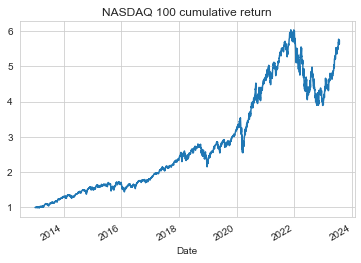

In [7]:
sns.set_style("whitegrid")  # You can choose different styles like "whitegrid", "dark", "white", etc.
nasdaq_original_return = nasdaq_original["Adj Close"]/nasdaq_original["Adj Close"].shift(1)
nasdaq_original_return = nasdaq_original_return.iloc[1:]
nasdaq_original_return.cumprod().plot(title = "NASDAQ 100 cumulative return")

## Components of NASDAQ 100

In [8]:
#Download the NASDAQ 100 components
nasdaq_data = get_nasdaq_data(NASDAQ_100_components)
nasdaq_adj_close = nasdaq_data["Adj Close"]

[*********************100%***********************]  97 of 97 completed
Data saved at nasdaq_components_data.pkl


In [9]:
nasdaq_data.head(3)

Adj Close                                                         \
                ABNB       ADBE        ADI        ADP       ADSK        AEP   
Date                                                                          
2013-01-02       NaN  38.340000  34.611385  40.575188  36.939999  29.987427   
2013-01-03       NaN  37.750000  34.052883  40.735027  36.369999  29.966814   
2013-01-04       NaN  38.130001  33.447189  41.096371  36.360001  29.918730   

                                                   ...    Volume            \
                 ALGN       AMAT   AMD       AMGN  ...      TSLA       TXN   
Date                                               ...                       
2013-01-02  28.400000  10.091087  2.53  67.581932  ...  17922000  13357500   
2013-01-03  29.170000  10.065519  2.49  67.157425  ...  11130000   8832500   
2013-01-04  29.309999  10.065519  2.59  67.453056  ...  10110000   7606600   

                                                                           
               VRSK     VRTX       WBA      WBD     WDAY      XEL  ZM  ZS  
Date                                                                       
2013-01-02  1305600  1790600  10064100  3077187  1103500  2702000 NaN NaN  
2013-01-03  1201700  1841500   7142300  2030192   433800  2403600 NaN NaN  
2013-01-04   692300  2538100   8324800  1715898   547800  1750100 NaN NaN  

[3 rows x 582 columns]

## Data preprocessing:
* drop the column, which is an asset ticker, if the missing data is more than 5%
* ffill the column if the missing data is less than 5%

In [10]:
def drop_and_ffill_by_threshold(df, threshold, axis=0):
    if axis == 0:
        # calculate missing value percent
        row_missing_percent = df.isnull().sum(axis=1) / df.shape[1] * 100
        # delete by row
        df_dropped = df.loc[row_missing_percent <= threshold]
        df_dropped = df_dropped.dropna()
        # ffill
        df_filled = df_dropped.ffill()
    elif axis == 1:
        # calculate missing value percent
        col_missing_percent = df.isnull().sum(axis=0) / df.shape[0] * 100
        # delete by column
        df_dropped = df.loc[:, col_missing_percent <= threshold]
        # ffill
        df_filled = df_dropped.ffill(axis=1)
    else:
        raise ValueError("Invalid axis value. axis must be 0 or 1.")
    
    #drop the first few lines missing, just to double check there is no missing value
    df_filled = df_filled.dropna()
    return df_filled

## Asset returns

We will only model investments held for one period. The initial prices are $p_i > 0$. The end of period prices are $p_i^+ >0$. The asset (fractional) returns are $r_i = (p_i^+-p_i)/p_i$. The porfolio (fractional) return is $R = r^Tw$.

A common model is that $r$ is a random variable with mean ${\bf E}r = \mu$ and covariance ${\bf E{(r-\mu)(r-\mu)^T}} = \Sigma$.
It follows that $R$ is a random variable with ${\bf E}R = \mu^T w$ and ${\bf var}(R) = w^T\Sigma w$.
${\bf E}R$ is the (mean) *return* of the portfolio. ${\bf var}(R)$ is the *risk* of the portfolio.
(Risk is also sometimes given as ${\bf std}(R) = \sqrt{{\bf var}(R)}$.)

Portfolio optimization has two competing objectives: high return and low risk.

## Classical (Markowitz) portfolio optimization

Classical (Markowitz) portfolio optimization solves the optimization problem

$$
\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\mbox{subject to} & {\bf 1}^T w = 1, \quad w \in {\cal W},
\end{array}
$$

where $w \in {\bf R}^n$ is the optimization variable, $\cal W$ is a set of allowed portfolios (e.g., ${\cal W} = {\bf R}_+^n$ for a long only portfolio), and $\gamma >0$ is the *risk aversion parameter*.

The objective $\mu^Tw - \gamma w^T\Sigma w$ is the *risk-adjusted return*. Varying $\gamma$ gives the optimal *risk-return trade-off*.
We can get the same risk-return trade-off by fixing return and minimizing risk.

## Portfolio construction
Every month calculate the optimal weight from the historical past 1 year return, and keep the weight as a portfolio until next rebalance

We add one extra constraint that we are building a LONG ONLY portfolio

In [11]:
nasdaq_return = nasdaq_adj_close/nasdaq_adj_close.shift(1) - 1
nasdaq_return = nasdaq_return.iloc[1:,:]
gamma_lists = [0.3, 0.5, 0.7, 1, 1.5] #risk averse level grid search
backtest_results = {}

for gamma_value in gamma_lists:
    portfolio_returns = []
    for i in range(252, len(nasdaq_return)):
        #initialize
        optimized_w = []
        portfolio = 0

        #rebalance the portfolio every month
        if (i-252)%22 == 0: 
            temp = nasdaq_return.iloc[i-252:i, :]
            temp = drop_and_ffill_by_threshold(temp, threshold = 5, axis = 1)
            tickers = temp.columns #save the ticker
            mu = np.array(temp.mean()) #mean of return
            Sigma = np.array(temp.cov()) #covariance of return

            w = cp.Variable(len(mu))
            gamma = cp.Parameter(nonneg=True)
            ret = mu.T @ w
            risk = cp.quad_form(w, Sigma)
            prob = cp.Problem(cp.Maximize(ret - gamma*risk), [cp.sum(w) == 1, w >= 0])

            #get the optimized weight
            gamma.value = gamma_value #gamma updates
            prob.solve()
            risk_data = cp.sqrt(risk).value
            ret_data = ret.value          
            optimized_w = w.value

            position = pd.Series(optimized_w, index = tickers)
            position = dict(position)

        #portfolio weights aggregation
        for ticker in position.keys():
            stock_return = nasdaq_return[ticker].iloc[i]
            weight = position[ticker]
            portfolio += stock_return*weight

        portfolio_returns.append(portfolio + 1)
    nasdaq_return_backtest = pd.Series(portfolio_returns, index = nasdaq_return.index[252:])
    backtest_results[gamma_value] = nasdaq_return_backtest

In [12]:
backtest_results = pd.DataFrame(backtest_results)

## Plot cumulative return

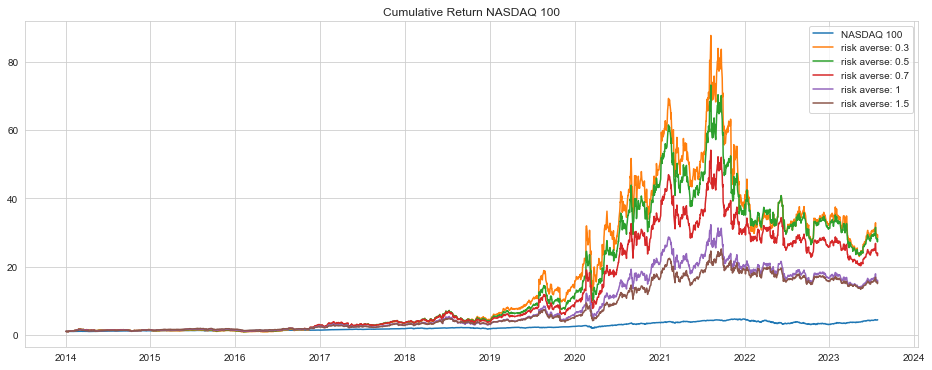

In [13]:
# Set the canvas size
plt.figure(figsize=(16, 6))  # Width: 10 inches, Height: 6 inches

# Set a stylish theme
sns.set_style("whitegrid")  # You can choose different styles like "whitegrid", "dark", "white", etc.

plt.title("Cumulative Return NASDAQ 100")
plt.plot(list(nasdaq_original_return.iloc[252:].index),np.array(nasdaq_original_return.iloc[252:].cumprod()), label = "NASDAQ 100")
for gamma in gamma_lists:
    plt.plot(list(backtest_results.index), np.array(backtest_results.cumprod()[gamma]), label = "risk averse: " + str(gamma))
plt.legend()

plt.show()

## Analysis

Compare the performance by:
* Sharpe Ratio
* Annual Max Drawdown

We don't have the risk free rate data, in our own coding version, just use 0 rate for now

In [14]:
def sharpe_ratio(returns, risk_free_rate):
    # Calculate the average return
    avg_return = np.mean(returns - 1)

    # Calculate the standard deviation of returns
    std_dev = np.std(returns - 1)

    # Calculate the Sharpe ratio
    sharpe_ratio = (avg_return - risk_free_rate) / std_dev

    return sharpe_ratio * np.sqrt(252) #annualize sharpe ratio

In [15]:
def calculate_maximum_drawdown(returns):
    # Calculate the cumulative returns
    cumulative_returns = returns.cumprod()

    # Compute the cumulative maximum value
    cumulative_max = cumulative_returns.cummax()

    # Calculate the drawdown
    drawdown = (cumulative_max - cumulative_returns)/cumulative_max

    # Find the maximum drawdown
    max_drawdown = drawdown.max()

    return max_drawdown

In [16]:
backtest_results["original"] = nasdaq_original_return.iloc[252:]
backtest_results.head()

,0.3,0.5,0.7,1.0,1.5,original
Date,,,,,,
2014-01-03,0.997658,0.998070,0.998246,0.995121,0.989544,0.993029
2014-01-06,0.985009,0.985705,0.986003,0.986123,0.986116,0.996674
2014-01-07,0.995393,0.988628,0.985729,0.991247,1.002968,1.008758
2014-01-08,1.010421,1.009624,1.009283,1.018636,1.035193,1.002724
2014-01-09,0.979016,0.980262,0.980795,0.980301,0.979052,0.995807


In [17]:
#calculate Sharpe Ratio by years
years = [date.strftime("%Y") for date in list(backtest_results.index)]
years = list(dict.fromkeys(years))

sharpes_by_years = {}
max_drawdown_by_years = {}
for year in years:
    selected = backtest_results[backtest_results.index.year == int(year)]
    sharpe = selected.apply(lambda x: sharpe_ratio(x, 0), axis = 0) #assuming rate = 0, not exactly right
    max_drawdown = selected.apply(lambda x: calculate_maximum_drawdown(x), axis = 0)
    sharpes_by_years[year] = sharpe
    max_drawdown_by_years[year] = max_drawdown

In [18]:
#Sharpe ratio by year
pd.DataFrame(sharpes_by_years)

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0.3,1.135459,-0.447481,1.650399,0.812435,0.755312,2.084050,1.722728,-0.001297,-0.075397,-0.138900
0.5,1.092508,-0.200190,1.740088,0.703480,0.594954,1.849744,1.932160,-0.000309,-0.087904,-0.265281
0.7,1.087724,0.042810,1.689833,0.645750,0.466685,1.625078,1.972352,0.141421,-0.191015,-0.225889
1.0,1.013172,0.306714,1.411420,0.572782,0.427789,1.363693,1.958950,0.240366,-0.312093,-0.117711
1.5,1.139091,0.651216,1.104753,0.665664,0.562585,1.095520,1.980830,0.582689,-0.408471,-0.040242
original,1.307741,0.543228,0.435601,2.734812,0.067460,2.056499,1.252017,1.368307,-1.075273,3.425810


In [19]:
#Maximum annual drawdown by year, percent
pd.DataFrame(max_drawdown_by_years)

,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0.3,0.357926,0.358933,0.296482,0.339474,0.479947,0.484640,0.594009,0.582240,0.418076,0.386893
0.5,0.361052,0.353234,0.296482,0.339474,0.479947,0.484640,0.594009,0.521258,0.377762,0.337590
0.7,0.360462,0.339577,0.296482,0.339473,0.483486,0.499864,0.594009,0.456216,0.338626,0.295476
1.0,0.351972,0.282523,0.280733,0.339789,0.466709,0.520560,0.593416,0.406178,0.299063,0.255720
1.5,0.300597,0.230253,0.263066,0.269994,0.386921,0.499485,0.553249,0.355750,0.260461,0.220122
original,0.082328,0.141753,0.122294,0.048993,0.229868,0.110596,0.280329,0.109259,0.352837,0.075986


## Apply pyfolio for portfolio analysis
* performance statistics analysis
* graphical reports

In [20]:
perf_analysis = {}
for gamma in gamma_lists:
    stock_rets = backtest_results[gamma]
    stock_rets = stock_rets - 1
    performance_stats = pf.timeseries.perf_stats(stock_rets)
    perf_analysis[gamma] = performance_stats
stock_rets = backtest_results["original"]
stock_rets = stock_rets - 1
perf_analysis["original"] = pf.timeseries.perf_stats(stock_rets)
perf_analysis = pd.DataFrame(perf_analysis)

In [21]:
perf_analysis

,0.3,0.5,0.7,1,1.5,original
Annual return,0.424005,0.417801,0.394055,0.336221,0.331423,0.168272
Cumulative returns,28.301371,27.103993,22.915217,14.952856,14.413749,3.419986
Annual volatility,0.637918,0.592608,0.563963,0.524732,0.457394,0.219537
Sharpe ratio,0.869868,0.883099,0.869517,0.814820,0.856030,0.818746
Calmar ratio,0.574391,0.612562,0.629094,0.566587,0.599048,0.473165
Stability,0.879909,0.893696,0.902320,0.902462,0.922476,0.932151
Max drawdown,-0.738182,-0.682055,-0.626384,-0.593416,-0.553249,-0.355631
Omega ratio,1.180303,1.183126,1.180398,1.168398,1.174398,1.162707
Sortino ratio,1.325458,1.334037,1.298335,1.190963,1.231617,1.153623
Skew,0.733304,0.693808,0.638511,0.384376,-0.028494,-0.350105


Below graphs are plotted based on the original NASDAQ 100, they provided perspectives on the benchmark performance

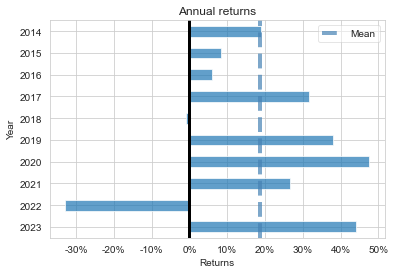

In [22]:
pf.plotting.plot_annual_returns(stock_rets)

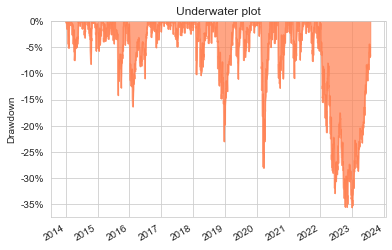

In [23]:
pf.plotting.plot_drawdown_underwater(stock_rets)

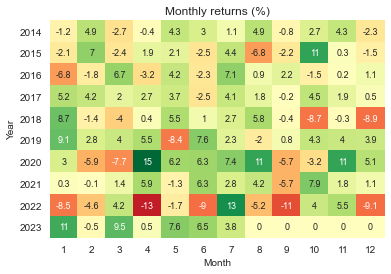

In [24]:
pf.plotting.plot_monthly_returns_heatmap(stock_rets)

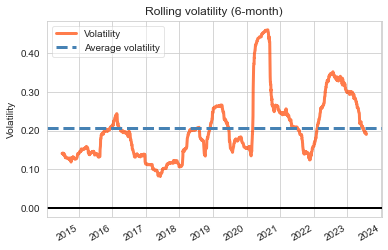

In [25]:
pf.plotting.plot_rolling_volatility(stock_rets)